In [3]:
## Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud


In [4]:
### Function to check if csv is cleaned

file = "netflix_titles1.csv"

def csv_cleaned_uncleaned(file):
    data = pd.read_csv(file)
    
    missing_val = data.isnull().sum().sum()
    duplicate_rows = data.duplicated().sum()
    numerical_cols = data.select_dtypes(include=["number"])
    outliers = ((numerical_cols - numerical_cols.mean().abs() > 3 * numerical_cols.std()).sum().sum())

    # Count number of object type columns (which can be inconsistent if not expected)
    invalid_types = sum(data.dtypes == "object")

    print(f"Missing Values: ", {missing_val})
    print(f"Duplicate rows ", { duplicate_rows})
    print(f"Outliers ", {outliers})
    print(f"Inconsistent data types", {invalid_types})

    return missing_val == 0 and duplicate_rows == 0 and outliers < 10

file_path = "netflix_titles.csv"
is_clean = csv_cleaned_uncleaned(file)

if is_clean :
    print("The dataset is considered clean !")
else:
    print("The dataset is  not cleaned !")

Missing Values:  {4307}
Duplicate rows  {0}
Outliers  {0}
Inconsistent data types {11}
The dataset is  not cleaned !


#### Load and Inspect the Netflix Dataset

In [7]:
## Load CSV file
file = "netflix_titles1.csv"
data = pd.read_csv(file)

## Preview the first 6 rows
print("First 6 rows of the dataset:")
print(data.head(6))

## Basic dataset information
print("Dataset Info:")
print(data.info())

## Dataset shape
print("Dataset Shape:")
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")

## Check for missing values in each column
print(" Missing Values:")
missing_values = data.isnull().sum()
print(missing_values)

## Check for duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"Duplicate Rows: {duplicate_rows}")

## Descriptive statistics for numerical columns
print("Summary Statistics:")
summary = data.describe()
print(summary)



First 6 rows of the dataset:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   
5      s6  TV Show          Midnight Mass    Mike Flanagan   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   
5  Kate Siegel, Zach Gilford, Hamish Linklater, H...            NaN   

           date_added  release_year ra

#### Cleaning CSV file

In [9]:
## Load the dataset
data = pd.read_csv('netflix_titles1.csv')  

## Standardize different types of missing values
missing_cols = ['date_added', 'rating', 'duration']
for col in missing_cols:
    data[col] = data[col].replace(['none', 'None', '', 'NaN', None], np.nan)

## Convert 'date_added' to datetime
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')

## Fill missing values
data['director'] = data['director'].fillna('Not specified')
data['cast'] = data['cast'].fillna('Not specified')
data['country'] = data['country'].fillna('Not specified')



if not data['rating'].mode().empty:
    data['rating'] = data['rating'].fillna(data['rating'].mode()[0])

if not data['duration'].mode().empty:
    data['duration'] = data['duration'].fillna(data['duration'].mode()[0])

if not data['date_added'].mode().empty:
    data['date_added'] = data['date_added'].fillna(data['date_added'].mode()[0])


## Create new columns for month and year
data['month'] = data['date_added'].dt.month
data['year'] = data['date_added'].dt.year

## Drop duplicates
data.drop_duplicates(inplace=True)

## Clean and standardize text columns
text_cols = ['type', 'title', 'director', 'cast', 'country', 'rating', 'listed_in', 'description']
for col in text_cols:
    data[col] = data[col].astype(str).str.strip().str.lower()

## Remove old content
data = data[data['release_year'] >= 1950]

## Split multi-valued columns into lists
data['listed_in'] = data['listed_in'].str.replace(r'\s*,\s*', ',', regex=True).str.split(',')
data['cast'] = data['cast'].str.replace(r'\s*,\s*', ',', regex=True).str.split(',')

## Final check
print("Missing values after cleaning:")
print(data.isnull().sum())
print("\nDataset preview:")
print(data.head())


Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
month           0
year            0
dtype: int64

Dataset preview:
  show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water    not specified   
2      s3  tv show              ganglands  julien leclercq   
3      s4  tv show  jailbirds new orleans    not specified   
4      s5  tv show           kota factory    not specified   

                                                cast        country  \
0                                    [not specified]  united states   
1  [ama qamata, khosi ngema, gail mabalane, thaba...   south africa   
2  [sami bouajila, tracy gotoas, samuel jouy, nab...  not specified   
3                            

In [103]:
data.to_csv("netflix_titles_cleaned.csv", index = False)

#### Content Type Ratio: Movies vs TV Shows

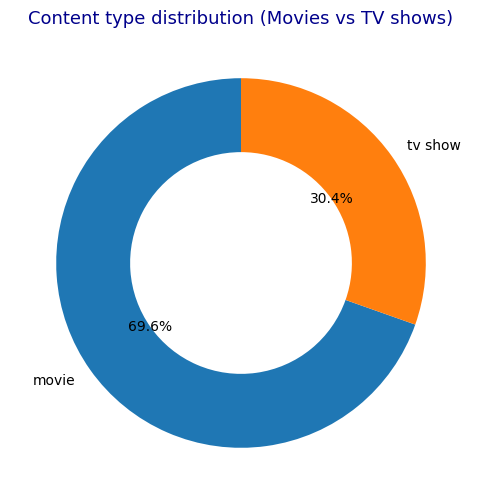

In [11]:
## Count how many Movies and TV Shows are in the dataset
type_counts = data['type'].value_counts()

## Plotting the donut-style pie chart 
plt.figure(figsize = (6,6))
plt.pie(
    type_counts,
    labels = type_counts.index,
    autopct = '%1.1f%%',
    startangle = 90,
    wedgeprops = {'width': 0.4}
)
plt.title("Content type distribution (Movies vs TV shows)", fontsize = 13, color = 'darkblue')
plt.show()


#### Genre Richness: Most Popular Genres on Netflix

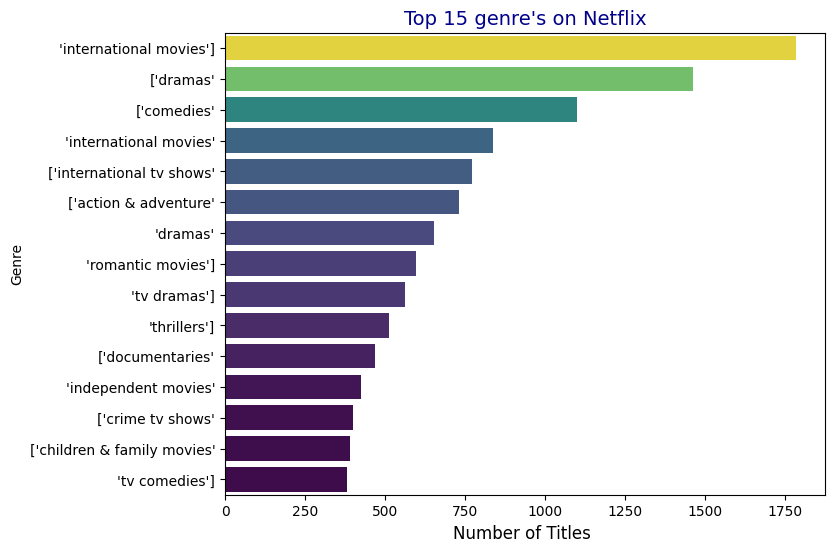

In [13]:
## Clean and split genre column
data['listed_in'] = data['listed_in'].fillna('').astype(str).str.split(', ')
genre_list = data['listed_in'].explode().dropna()
top_genres = Counter(genre_list)
top_genres = dict(sorted(top_genres.items(), key = lambda x : x[1], reverse = True)[:15])

## Create DataFrame for plotting
genre_df = pd.DataFrame({
    'genre' : list(top_genres.values()),
    'cast'  : list(top_genres.keys())
})

### Plotting the top 15 genres
plt.figure(figsize = (10,6))
sns.barplot(data = genre_df, x='genre', y='cast',  hue='genre', palette='viridis', legend=False, dodge=False)
plt.title("Top 15 genre's on Netflix", fontsize= 14, color = "Darkblue")
plt.xlabel("Number of Titles ", fontsize = 12 )
plt.ylabel("Genre", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.subplots_adjust(left=0.3)
plt.show()


#### Trend of Releases Over the Years (Movies vs TV Shows)

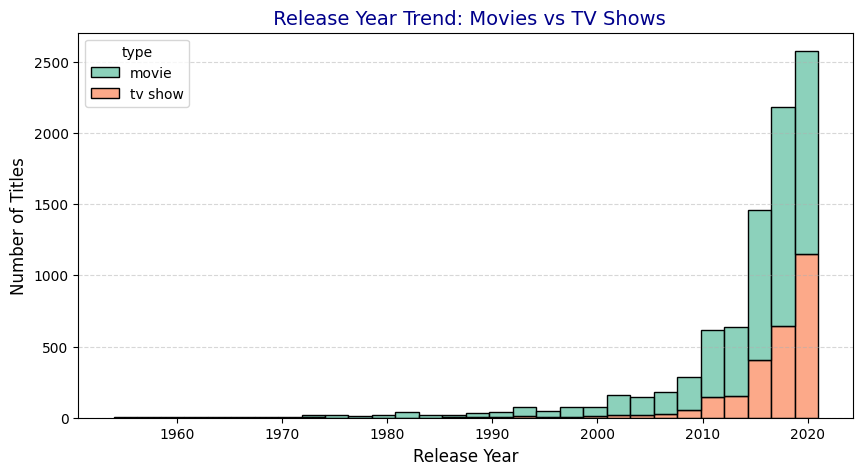

In [15]:
## reate a stacked histogram by release year and content type
plt.figure(figsize=(10, 5))
sns.histplot(
    data=data,
    x='release_year',
    hue='type',
    multiple='stack',
    bins=30,
    palette='Set2'
)

## Customize the chart
plt.title(" Release Year Trend: Movies vs TV Shows", fontsize=14, color='darkblue')
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


#### Heatmap: Visualizing How Much Content Was Added Over Time (Year vs Month)

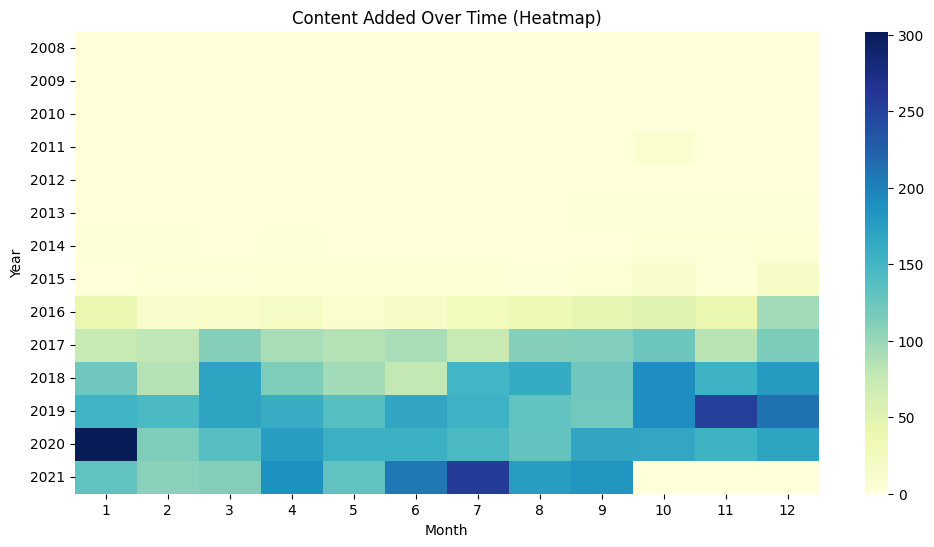

In [17]:
## Group the data by year and month to count titles
monthly_data = data.groupby(['year', 'month']).size().unstack(fill_value=0)

## Plot heatmap 
plt.figure(figsize=(12,6))
sns.heatmap(monthly_data, cmap='YlGnBu')
plt.title('Content Added Over Time (Heatmap)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


#### Top 10 Directors and Actors based on number of titles

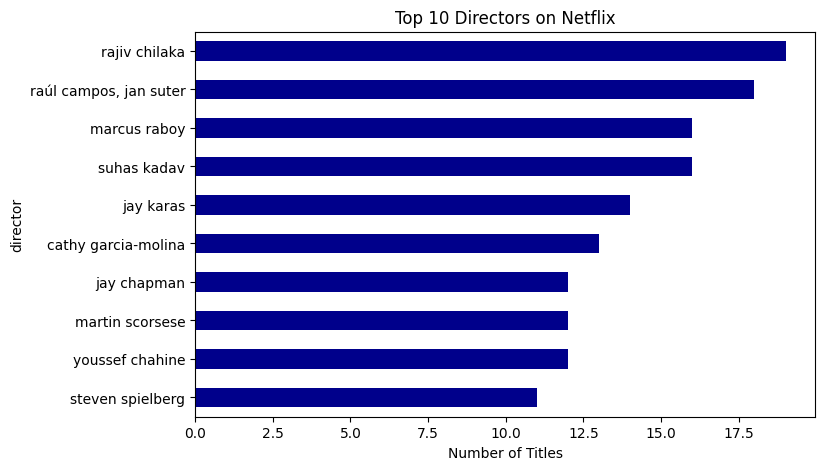

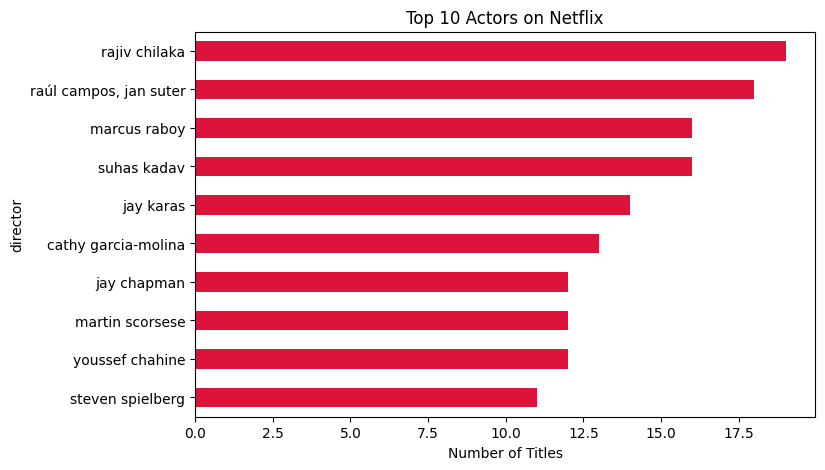

In [31]:
## Get top 10 directors and actors
filtered_directors = data['director'][data['director'] != 'not specified']
top_directors = filtered_directors.explode().value_counts().head(10).sort_values(ascending=True) 

filtered_actors = data['cast'][data['cast'] != 'not specified']
top_actors = filtered_directors.explode().value_counts().head(10).sort_values(ascending=True) 

## Plot top directors
plt.figure(figsize=(8, 5))
top_directors.plot(kind='barh', color='darkblue')
plt.xlabel("Number of Titles")
plt.title("Top 10 Directors on Netflix")
plt.show()

## Plot top actors
plt.figure(figsize=(8, 5))
top_actors.plot(kind='barh', color='crimson')
plt.xlabel("Number of Titles")
plt.title("Top 10 Actors on Netflix")
plt.show()

#### Word Cloud: Most Frequent Words in Descriptions

In [ ]:
## Import and combine all text from the 'description' column (drop any missing values)
text = ' '.join(data['description'].dropna().astype(str).str.strip())

## Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

## Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Netflix Descriptions', color='red', fontsize=15)
plt.show()
